In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [18]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12,4)

# The JPA equations

A driven, parametrically modulated Duffing equation:

$$
\ddot x + \gamma x + \omega_0^2 \big(1 + \epsilon \cos(\omega_p t + \phi)\big) + \alpha x^3= F \cos(\omega_s t)
$$

Note that $\phi$ is only relevant for the so-called "degerate amplifier" condition, $\omega_p = 2 \omega_s$. 

Typically, $\omega_s = \omega_0 + \Delta$, where $\Delta < \gamma$. And $\omega_p = 2\omega_0$ (first order parametric resonance condition). 

We will pick $\omega_0 = 1$:

$$
\ddot x + \gamma x + \big(1 + \epsilon \cos(\omega_p t + \phi)\big) + \alpha x^3 = F \cos(\omega_s t)
$$

In [122]:
def solve_and_plot():
    # State vector y: 
    # y[0] = x
    # y[1] = v

    def dydt(t,y):
        x = y[0]
        v = y[1]
        dxdt = v
        dvdt = (F*np.cos(ws*t) - gam*v - x*(1+eps*np.cos(wp*t+phi)) - alpha*x**3)
        return (dxdt, dvdt)
    
    t = np.linspace(0,T,N)
    sol = solve_ivp(dydt, [0,T], [0,0], t_eval=t, method="BDF")
    x = sol.y[0]
    plt.plot(t,x)
    return t,x

First, start with something we know should work: the driven HO

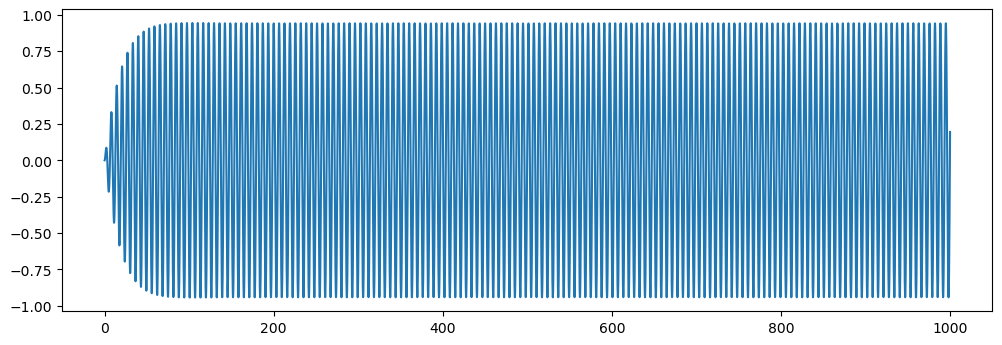

In [132]:
T = 1000
gam = 0.1
eps = 0.0
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
t0,x0 = solve_and_plot()

Now, let's put in parametric modulation in non-degenerate condition: 

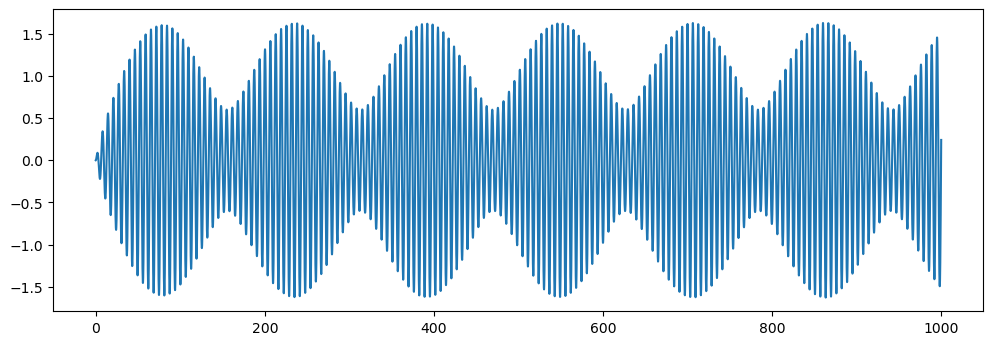

In [133]:
T = 1000
gam = 0.1
eps = 0.1
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
t1,x1 = solve_and_plot()

Now let's add some Duffing and see what happens:

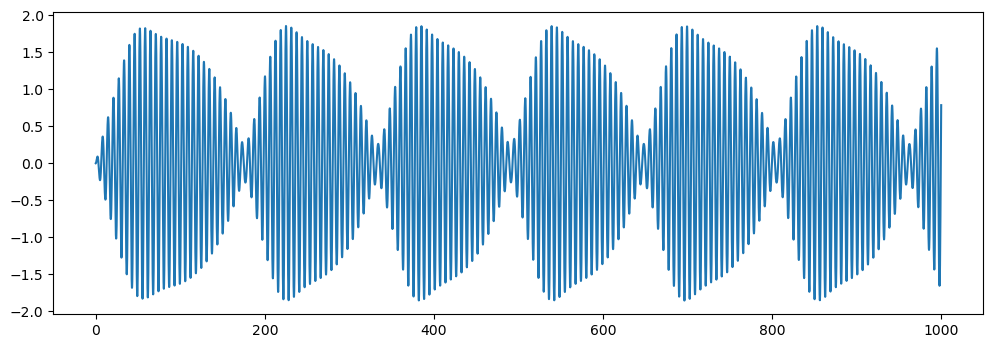

In [148]:
T = 1000
gam = 0.1
eps = 0.2
F = 0.1
alpha = 0.05
N = 10000
ws = 0.98
wp = 2
t2,x2 = solve_and_plot()

Here, we can see saturation already:

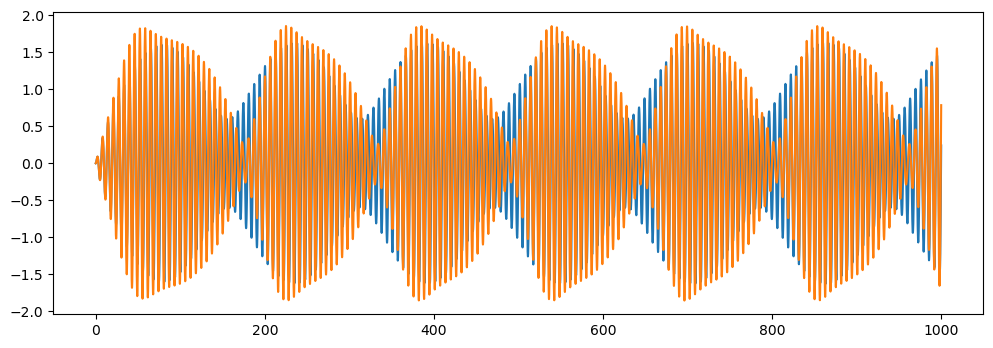

In [149]:
plt.plot(t1,x1)
plt.plot(t2,x2)

## Spectral analysis of the results

In [159]:
def plot_spec(x, lab=""):
    Nf = len(x)*10
    xf = np.fft.fft(x, Nf)
    w = np.fft.fftfreq(Nf, d = T/(N-1))*2*np.pi
    xf = xf[0:N//2]
    w = w[0:N//2]
    plt.plot(w,np.abs(xf)**2, label=lab)
    plt.xlim(0.9,1.2)

Text(1.063, 29000000.0, 'Second Idler (Upper)')

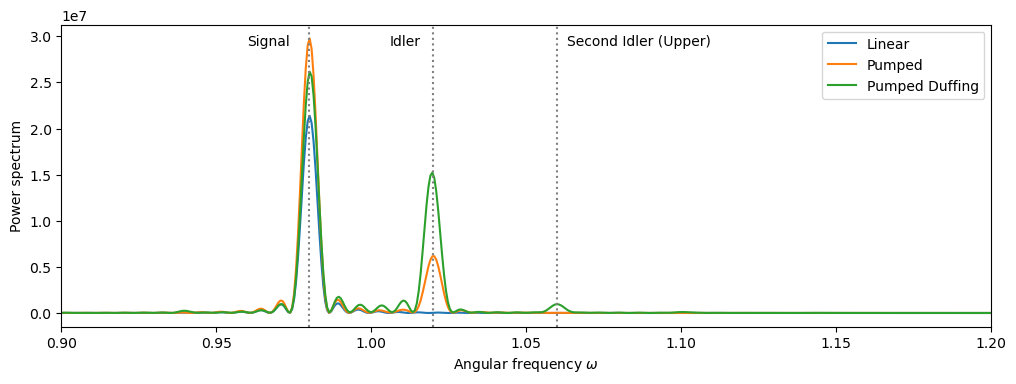

In [177]:
plot_spec(x0, "Linear")
plot_spec(x1, "Pumped")
plot_spec(x2, "Pumped Duffing")
plt.axvline(0.98, ls=":", c='grey')
plt.axvline(1.02, ls=":", c='grey')
plt.axvline(1.06, ls=":", c='grey')
plt.legend()
plt.xlabel("Angular frequency $\omega$")
plt.ylabel("Power spectrum")
plt.text(0.96, 2.9e7, "Signal")
plt.text(1.006, 2.9e7, "Idler")
plt.text(1.063, 2.9e7, "Second Idler (Upper)")

This makes sense since a positive $\alpha$ will shift the susceptibility of the resonance to higher frequencies, which is why the idler gain is actually enhanced, while the signal gain is reduced. 

We also see the appearance of a second idler sideband at higher frequencies due to higher order mixing. 